CS7140

Rajesh Sakhamuru

Zhiyu Chen

# CNN Model for mRNA Degredation Prediction using embedding layer and filtering noisy data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import json
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataFolder = "drive/MyDrive/Colab Notebooks/CS7140 Final Project/stanford-covid/"
testPath = dataFolder + "test.json"
trainPath = dataFolder + "train.json"

In [ ]:
def oneHotEncode(rowDict):
    """
    One-hot encode a single sample's sequence data
    """
    categories = ['ACGU', '.()', 'BEHIMSX']

    seq = rowDict['sequence']
    oneHotSeq = np.zeros((len(seq),3))
    for i, char in enumerate(seq):
        oneHotSeq[i,0] = 1+categories[0].index(char)

    struc = rowDict['structure']
    for i, char in enumerate(struc):
        oneHotSeq[i,1] = 5+categories[1].index(char)

    loop = rowDict['predicted_loop_type']
    for i, char in enumerate(loop):
        oneHotSeq[i,2] = 9+categories[2].index(char)

    return oneHotSeq

In [ ]:
def encode_timeSteps(idx, oneHotRow, numFeatures):
    """
    Each timestep per one hot encoded row is encoded as just 
    the surrounding characters, and not the entire sequence, so that
    the entire length of the sequence doesn't really matter for predictions
    """
    halfNumFeats = (numFeatures-1)//2
    if idx-halfNumFeats<0:
        timeStepFeats = oneHotRow[:idx+halfNumFeats+1]
        padding = np.array([[0,5,9]]*int(halfNumFeats-idx),dtype=int)
        timeStepFeats = np.vstack([timeStepFeats,padding])

    elif idx+halfNumFeats+1>len(oneHotRow):
        timeStepFeats=oneHotRow[idx-halfNumFeats:]
        padding = np.array([[0,5,9]]*(int(halfNumFeats-(len(oneHotRow)-idx))+1),dtype=int)
        timeStepFeats = np.vstack([timeStepFeats,padding])

    else:
        timeStepFeats = oneHotRow[idx-halfNumFeats:idx+halfNumFeats+1]
    
    return timeStepFeats

In [ ]:
class prepDataset(Dataset):
    """
    Load each one-hot timestep as a separate 'image' tensor, for training CNN
    Ignores Noisy data which can tarnish results
    """
    def __init__(self, path, testFlag=False):
        self.path = path
        self.testFlag = testFlag
        self.features = []
        self.targets = []
        self.ids = []
        self.loadData()
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.testFlag:
            return self.features[idx].astype(int), self.ids[idx]
        else:
            return self.features[idx].astype(int), self.targets[idx], self.ids[idx]

    def loadData(self):
        with open(self.path, 'r') as data:
            for row in data:
                rowDict = json.loads(row)
                # Ignore Noisy Data
                if not self.testFlag:
                  if rowDict['SN_filter']==0:
                    continue
                oneHotRow = oneHotEncode(rowDict)
                # Encode each time-step as an 'image' for CNN
                for i in range(rowDict['seq_scored']):
                    timeStepFeats = encode_timeSteps(i, oneHotRow, 21)
                    self.features.append(timeStepFeats)
                    self.ids.append('%s_%d' % (rowDict['id'], i))
                    
                if not self.testFlag:
                    targets = np.stack([rowDict['reactivity'], rowDict['deg_Mg_pH10'], rowDict['deg_Mg_50C']], axis=1)
                    self.targets.extend([targets[i] for i in range(rowDict['seq_scored'])])           

In [ ]:
class reactivityModel(nn.Module):
    """
    CNN model with convolution, pooling, dropout and dense layers
    Now uses embedding instead of 1-hot encoding
    """
    def __init__(self,embed_dim=50):
        super(reactivityModel, self).__init__()
        self.embedding=nn.Embedding(17, embed_dim)
        self.convBlock = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim*3,out_channels=32,kernel_size=1,stride=1),
            nn.BatchNorm1d(num_features=32),
            nn.PReLU(),
            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=5,stride=1),
            nn.BatchNorm1d(num_features=64),
            nn.PReLU(),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1,stride=1),
            nn.PReLU(),
            nn.MaxPool1d(3, stride=2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.PReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(0.4),
            nn.Linear(64, 64),
            nn.PReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )

    def forward(self, X):
      embedding_layer=self.embedding(X)
      embedding_reshape= torch.reshape(embedding_layer,(-1, embedding_layer.shape[1], embedding_layer.shape[2]*embedding_layer.shape[3])).permute(0,2,1)
      output = self.convBlock(embedding_reshape)
      return output

In [ ]:
def trainModel(trainDataLoader, epochs = 25, lr = 0.001, weightsPath = 'drive/MyDrive/Colab Notebooks/CS7140Models/Emb_Clean_covidCNNModel.pth'):
    """
    Trains the CNN model for specified number of epochs at the specified learning rate.
    """
    model = reactivityModel().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossFunc = nn.MSELoss()
    loss_list=[]
    for epoch in range(epochs):
        lossList = []
        model.train()
        for features, targets, ids in trainDataLoader:
            features = torch.tensor(features).to(torch.int64).to(device)
            targets = torch.tensor(targets).to(torch.float).to(device)
            predictions = model(features)
            loss = lossFunc(predictions, targets)

            for p in model.parameters():
                p.grad = None
            
            loss.backward()
            optimizer.step()
            lossList.append(loss.detach().cpu().numpy())
        
        avg_loss = float(np.mean(lossList))
        loss_list.append(avg_loss)
    plt.plot(loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    torch.save(model.state_dict(), weightsPath)

In [ ]:
trainDataset = prepDataset(trainPath,testFlag=False)
trainDataLoader = DataLoader(trainDataset, batch_size=256, shuffle=True, num_workers=4,pin_memory=True)

In [ ]:
for feature,labels,ids in trainDataLoader:
  print(feature.shape)
  print(labels.shape)
  print(len(ids))
  break

torch.Size([256, 21, 3])
torch.Size([256, 3])
256


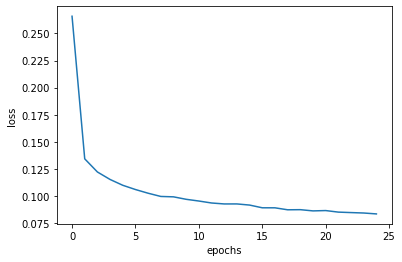

In [ ]:
weightsPath = 'drive/MyDrive/Colab Notebooks/CS7140 Final Project/CS7140Models/Emb_Clean_covidCNNModel.pth'
trainModel(trainDataLoader, epochs=25, lr=0.001, weightsPath=weightsPath)

In [ ]:
testDataset = prepDataset(testPath, testFlag=True)
testDataLoader = DataLoader(testDataset, batch_size=256, num_workers=4, drop_last=False, pin_memory=True)

In [ ]:
sampleSubmPath = dataFolder + "sample_submission.csv"
submissionDF = pd.read_csv(sampleSubmPath, index_col='id_seqpos')

model = reactivityModel().cuda()
model.load_state_dict(torch.load(weightsPath))
model.eval()
for testFeats, ids in testDataLoader:
    testFeats = testFeats.cuda()
    preds = model(testFeats)
    submissionDF.loc[ids,['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']] = preds.detach().cpu().numpy()
submissionDF[['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']].head()

,reactivity,deg_Mg_pH10,deg_Mg_50C
id_seqpos,,,
id_00073f8be_0,0.751224,0.683348,0.543136
id_00073f8be_1,1.987167,2.798665,2.681364
id_00073f8be_2,1.304582,0.756657,0.910535
id_00073f8be_3,1.158936,0.901483,1.100835
id_00073f8be_4,0.936200,1.101207,1.202086


In [ ]:
submissionDF.to_csv(dataFolder+'Emb_Clean_CNNSubmission.csv')

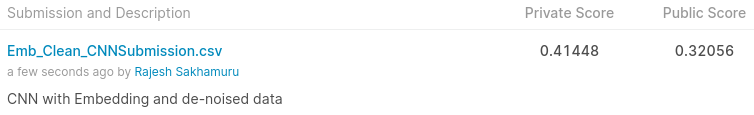

This model was a very slight/insignificant improvement over the original CNN model which was trained.

Embedding did not seem to make any difference here compared to one-hot encoding. Using denoised data also did not seem to make much of a difference, which could be due to the fact that this model is already not taking into account the relationship of the base with the entire mRNA sequence.

CNN is not a very good method for predicting sequence data, so the results were not competitive, but did manage to do better than a reasonable number of official submissions made during the actual competition.

The scores are based on MCRMSE (mean columnwise root mean squared error). The score which matters is the 'Public Score' which can be compared against other Kaggle user submissions from the actual competition.